In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
sns.set_theme(font="Arial", palette="deep")
sns.set(font="Arial")
%matplotlib inline
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# **Load and Explore Data**
---

In [3]:
# Load both train and test datasets
train_df = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv")

# List of dataframes
dfs = [("train", train_df), ("test", test_df)]
for name, df in dfs:
    print(f"The {name} contains {df.shape[0]} rows and {df.shape[1]} columns.")
    display(df.sample(n=8, random_state=42))
    print()

The train contains 140700 rows and 20 columns.


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
18347,18347,Sanya,Female,51.0,Patna,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,More than 8 hours,Moderate,B.Ed,No,11.0,2.0,Yes,0
96193,96193,Sneha,Female,20.0,Agra,Working Professional,NaN,NaN,1.0,NaN,NaN,4.0,Less than 5 hours,Moderate,Class 12,No,0.0,5.0,Yes,0
100005,100005,Aanchal,Female,21.0,Ahmedabad,Student,NaN,2.0,NaN,7.82,5.0,NaN,5-6 hours,Healthy,MA,Yes,12.0,2.0,Yes,0
39890,39890,Rahil,Male,36.0,Indore,Working Professional,Teacher,NaN,5.0,NaN,NaN,2.0,Less than 5 hours,Moderate,MBBS,No,1.0,1.0,No,0
98243,98243,Rishi,Male,60.0,Mumbai,Working Professional,HR Manager,NaN,2.0,NaN,NaN,2.0,5-6 hours,Moderate,BBA,No,6.0,2.0,No,0
88194,88194,Dhruv,Male,25.0,Varanasi,Working Professional,Teacher,NaN,1.0,NaN,NaN,5.0,Less than 5 hours,Moderate,B.Arch,No,1.0,2.0,No,0
102244,102244,Ritik,Male,56.0,Varanasi,Working Professional,Data Scientist,NaN,4.0,NaN,NaN,4.0,More than 8 hours,Healthy,BCA,Yes,3.0,4.0,Yes,0
8022,8022,Abhinav,Male,48.0,Nagpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,4.0,More than 8 hours,Unhealthy,B.Com,No,1.0,1.0,No,0



The test contains 93800 rows and 19 columns.


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
48587,189287,Ritik,Male,45.0,Varanasi,Working Professional,Business Analyst,NaN,2.0,NaN,NaN,5.0,7-8 hours,Healthy,M.Com,No,3.0,2.0,No
79643,220343,Eshita,Female,44.0,Kanpur,Working Professional,Marketing Manager,NaN,3.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,2.0,5.0,No
90518,231218,Aariv,Male,50.0,Nagpur,Working Professional,Entrepreneur,NaN,5.0,NaN,NaN,5.0,5-6 hours,Moderate,BCA,No,2.0,1.0,Yes
88332,229032,Aishwarya,Female,52.0,Mumbai,Working Professional,Investment Banker,NaN,4.0,NaN,NaN,2.0,Less than 5 hours,Moderate,MBA,Yes,5.0,5.0,Yes
28928,169628,Zoya,Female,40.0,Srinagar,Working Professional,Plumber,NaN,3.0,NaN,NaN,4.0,7-8 hours,Unhealthy,BE,Yes,0.0,5.0,No
22048,162748,Tushar,Male,40.0,Surat,Working Professional,Teacher,NaN,4.0,NaN,NaN,4.0,5-6 hours,Unhealthy,MSc,No,12.0,5.0,No
16069,156769,Anaya,Female,59.0,Bangalore,Working Professional,Consultant,NaN,3.0,NaN,NaN,4.0,7-8 hours,Healthy,ME,No,5.0,5.0,Yes
67497,208197,Pooja,Female,25.0,Indore,Student,NaN,5.0,NaN,6.83,5.0,NaN,7-8 hours,Unhealthy,B.Arch,Yes,10.0,4.0,Yes


In [4]:
# Normalize all values
for name, df in dfs:
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].str.strip().str.lower()

In [5]:
# Define a function to generate combined statistics
def get_combined_stats(data):
    # View columns and datatypes
    cols_dtype = data.dtypes.rename("Datatype").reset_index()
    cols_dtype = cols_dtype.rename(columns={"index": "Column"})

    # View missing values
    missing_count = data.isnull().sum().rename("Missing Value Count").reset_index()
    missing_count["% Missing"] = (
        (missing_count["Missing Value Count"] / len(data)) * 100)
    missing_count = missing_count.rename(columns={"index": "Column"})

    # View zero values
    zero_count = data.eq(0).sum().reset_index()
    zero_count.columns = ["Column", "Zero Value Count"]
    zero_count["% Zero"] = (
        (zero_count["Zero Value Count"] / len(data)) * 100).round(2)
    zero_count = zero_count.rename(columns={"index": "Column"})

    # View min and max values for numerical columns
    num_cols = data.select_dtypes(include=["int", "float"]).columns
    if not num_cols.empty:
        min_max_values = data[num_cols].agg(["min", "max"]).T
        min_max_values = min_max_values.rename(
            columns={"min": "Min Value", "max": "Max Value"})
        min_max_values.index.name = "Column"
    else:
        min_max_values = pd.DataFrame(columns=["Min Value", "Max Value"])
        min_max_values.index.name = "Column"

    # View min and max values for categorical columns
    obj_cols = data.select_dtypes(include=["object", "category"]).columns
    category_info = data[obj_cols].apply(
        lambda col: [col.value_counts().idxmin(), col.value_counts().idxmax()]).T
    category_info.columns = ["Min Value", "Max Value"]
    category_info.index.name = "Column"

    # View min and max values for datetime columns
    date_cols = data.select_dtypes(include=["datetime64[ns]"]).columns
    if not date_cols.empty:
        min_max_dates = data[date_cols].agg(["min", "max"]).T
        min_max_dates = min_max_dates.rename(
            columns={"min": "Min Value", "max": "Max Value"})
        min_max_dates.index.name = "Column"
    else:
        min_max_dates = pd.DataFrame(columns=["Min Value", "Max Value"])
        min_max_dates.index.name = "Column"

    combined_info = pd.concat(
        [min_max_values, category_info, min_max_dates], axis=0)

    # View count of unique values
    unique_count = data.nunique().rename("Unique Value Count").reset_index()
    unique_count = unique_count.rename(columns={"index": "Column"})

    # View list of unique values
    unique_values_list = []
    for col in data.columns:
        if len(data[col].unique()) > 40:
            unique_values_list.append(
                {"Column": col, "Unique Values": "Many unique values"})
        else:
            unique_values_list.append(
                {"Column": col, "Unique Values": data[col].unique()})
    unique_values_data = pd.DataFrame(unique_values_list).set_index("Column")

    # Combine all statistics
    combined_stats = cols_dtype.merge(missing_count, on="Column").merge(zero_count, on="Column").merge(
        combined_info, on="Column", how="left").merge(unique_count, on="Column", how="right").merge(unique_values_data, on="Column", how="left")
    
    display(combined_stats)
    return combined_stats

In [6]:
# View info for each dataset
for name, df in dfs:
    print(f"{name}")
    get_combined_stats(df)
    print()

train


,Column,Datatype,Missing Value Count,% Missing,Zero Value Count,% Zero,Min Value,Max Value,Unique Value Count,Unique Values
0,id,int64,0,0.000000,1,0.00,0.0,140699.0,140700,Many unique values
1,Name,object,0,0.000000,0,0.00,rupika,rohan,422,Many unique values
2,Gender,object,0,0.000000,0,0.00,female,male,2,"[female, male]"
3,Age,float64,0,0.000000,0,0.00,18.0,60.0,43,Many unique values
4,City,object,0,0.000000,0,0.00,m.tech,kalyan,98,Many unique values
5,Working Professional or Student,object,0,0.000000,0,0.00,student,working professional,2,"[working professional, student]"
6,Profession,object,36630,26.034115,0,0.00,dev,teacher,64,Many unique values
7,Academic Pressure,float64,112803,80.172708,0,0.00,1.0,5.0,5,"[nan, 5.0, 2.0, 3.0, 4.0, 1.0]"
8,Work Pressure,float64,27918,19.842217,0,0.00,1.0,5.0,5,"[5.0, 4.0, nan, 1.0, 2.0, 3.0]"
9,CGPA,float64,112802,80.171997,0,0.00,5.03,10.0,331,Many unique values



test


,Column,Datatype,Missing Value Count,% Missing,Zero Value Count,% Zero,Min Value,Max Value,Unique Value Count,Unique Values
0,id,int64,0,0.000000,0,0.00,140700.0,234499.0,93800,Many unique values
1,Name,object,0,0.000000,0,0.00,vane,rohan,374,Many unique values
2,Gender,object,0,0.000000,0,0.00,female,male,2,"[male, female]"
3,Age,float64,0,0.000000,0,0.00,18.0,60.0,44,Many unique values
4,City,object,0,0.000000,0,0.00,san vasai-virar,kalyan,68,Many unique values
5,Working Professional or Student,object,0,0.000000,0,0.00,student,working professional,2,"[working professional, student]"
6,Profession,object,24632,26.260128,0,0.00,unveil,teacher,64,Many unique values
7,Academic Pressure,float64,75033,79.992537,0,0.00,1.0,5.0,5,"[nan, 5.0, 1.0, 3.0, 4.0, 2.0]"
8,Work Pressure,float64,18778,20.019190,0,0.00,1.0,5.0,5,"[2.0, 4.0, nan, 5.0, 1.0, 3.0]"
9,CGPA,float64,75034,79.993603,0,0.00,5.03,10.0,326,Many unique values


In [7]:
# Rename long column names
column_mapping = {
    'Working Professional or Student': 'Status',
    'Academic Pressure': 'Acad_Pressure',
    'Work Pressure': 'Work_Pressure',
    'Study Satisfaction': 'Study_Sat',
    'Job Satisfaction': 'Job_Sat',
    'Sleep Duration': 'Sleep_Duration',
    'Dietary Habits': 'Diet_Habits',
    'Have you ever had suicidal thoughts ?': 'Suicidal_Thoughts',
    'Work/Study Hours': 'Work_Study_Hours',
    'Financial Stress': 'Fin_Stress',
    'Family History of Mental Illness': 'Family_History_MI'
}

# Normalize all values and Rename columns
for name, df in dfs:
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].str.strip().str.lower() 
    df.rename(columns=column_mapping, inplace=True)  
    print(f"The columns for the {name} dataset are {df.columns.tolist()}.\n")

The columns for the train dataset are ['id', 'Name', 'Gender', 'Age', 'City', 'Status', 'Profession', 'Acad_Pressure', 'Work_Pressure', 'CGPA', 'Study_Sat', 'Job_Sat', 'Sleep_Duration', 'Diet_Habits', 'Degree', 'Suicidal_Thoughts', 'Work_Study_Hours', 'Fin_Stress', 'Family_History_MI', 'Depression'].

The columns for the test dataset are ['id', 'Name', 'Gender', 'Age', 'City', 'Status', 'Profession', 'Acad_Pressure', 'Work_Pressure', 'CGPA', 'Study_Sat', 'Job_Sat', 'Sleep_Duration', 'Diet_Habits', 'Degree', 'Suicidal_Thoughts', 'Work_Study_Hours', 'Fin_Stress', 'Family_History_MI'].



In [8]:
# Convert binary columns
for name, df in dfs:
    for col in ['Suicidal_Thoughts', 'Family_History_MI']:
        df[col] = df[col].map({'yes': 1, 'no': 0}).fillna(-1)

In [9]:
def plot_donut_chart(df, column, colors=['#ff9999', '#66b3ff'], legend_labels=None):
    # Count the unique values
    value_counts = df[column].value_counts()

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%',
           startangle=90, pctdistance=0.8, colors=colors)

    # Draw a center circle for the donut hole
    center_circle = plt.Circle((0, 0), 0.60, fc='white')
    fig.gca().add_artist(center_circle)

    # Equal aspect ratio to ensure the chart is a circle
    ax.axis('equal')

    # Add a legend if labels are provided
    if legend_labels:
        plt.legend(legend_labels, loc='upper right', facecolor="white", edgecolor="black")

    # Display the plot
    plt.tight_layout()
    plt.show()

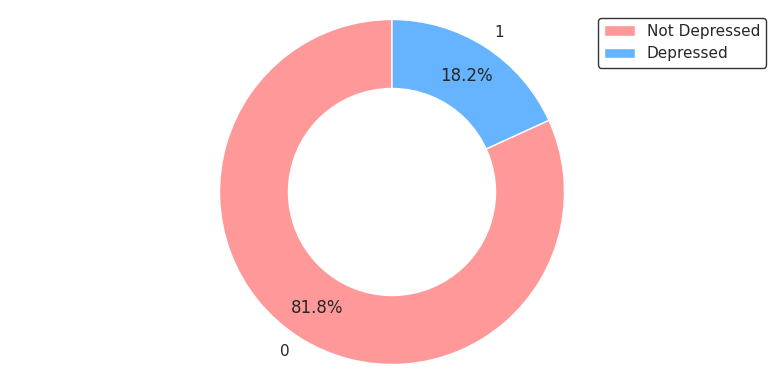

In [10]:
# Target label distribution
plot_donut_chart(train_df, "Depression", colors=['#ff9999', '#66b3ff'], legend_labels=['Not Depressed', 'Depressed'])

### **Split the data into Working Professional and Student**

In [11]:
# Filter rows by Status
student_df = train_df[train_df['Status'] == 'student']
working_df = train_df[train_df['Status'] == 'working professional']
student_test_df = test_df[test_df['Status'] == 'student']
working_test_df = test_df[test_df['Status'] == 'working professional']

In [12]:
# View info for each dataset
dfp =[("Working Professional", working_df), ("Student", student_df)]
for name, df in dfp:
    print(f"The {name} contains {df.shape[0]} rows and {df.shape[1]} columns.\n")
    get_combined_stats(df)
    print()

The Working Professional contains 112799 rows and 20 columns.



,Column,Datatype,Missing Value Count,% Missing,Zero Value Count,% Zero,Min Value,Max Value,Unique Value Count,Unique Values
0,id,int64,0,0.000000,1,0.00,0.0,140698.0,112799,Many unique values
1,Name,object,0,0.000000,0,0.00,ijra,rohan,380,Many unique values
2,Gender,object,0,0.000000,0,0.00,female,male,2,"[female, male]"
3,Age,float64,0,0.000000,0,0.00,18.0,60.0,43,Many unique values
4,City,object,0,0.000000,0,0.00,aishwarya,kalyan,84,Many unique values
5,Status,object,0,0.000000,0,0.00,working professional,working professional,1,[working professional]
6,Profession,object,8763,7.768686,0,0.00,dev,teacher,64,Many unique values
7,Acad_Pressure,float64,112794,99.995567,0,0.00,2.0,4.0,3,"[nan, 2.0, 4.0, 3.0]"
8,Work_Pressure,float64,20,0.017731,0,0.00,1.0,5.0,5,"[5.0, 4.0, 1.0, 2.0, 3.0, nan]"
9,CGPA,float64,112793,99.994681,0,0.00,5.42,9.72,6,"[nan, 8.14, 8.04, 8.11, 9.72, 5.42, 8.24]"



The Student contains 27901 rows and 20 columns.



,Column,Datatype,Missing Value Count,% Missing,Zero Value Count,% Zero,Min Value,Max Value,Unique Value Count,Unique Values
0,id,int64,0,0.000000,0,0.00,2.0,140699.0,27901,Many unique values
1,Name,object,0,0.000000,0,0.00,taurav,aarav,268,Many unique values
2,Gender,object,0,0.000000,0,0.00,female,male,2,"[male, female]"
3,Age,float64,0,0.000000,0,0.00,18.0,59.0,34,"[33.0, 24.0, 31.0, 28.0, 25.0, 29.0, 30.0, 27.0, 19.0, 20.0, 23.0, 18.0, 21.0, 22.0, 34.0, 32.0, 26.0, 39.0, 35.0, 42.0, 36.0, 58.0, 49.0, 38.0, 51.0, 44.0, 43.0, 46.0, 59.0, 54.0, 48.0, 56.0, 37.0, 41.0]"
4,City,object,0,0.000000,0,0.00,kibara,kalyan,52,Many unique values
5,Status,object,0,0.000000,0,0.00,student,student,1,[student]
6,Profession,object,27867,99.878141,0,0.00,civil engineer,architect,14,"[nan, civil engineer, architect, ux/ui designer, digital marketer, content writer, educational consultant, teacher, student, manager, chef, doctor, lawyer, entrepreneur, pharmacist]"
7,Acad_Pressure,float64,9,0.032257,0,0.00,1.0,5.0,5,"[5.0, 2.0, 3.0, 4.0, 1.0, nan]"
8,Work_Pressure,float64,27898,99.989248,0,0.00,2.0,5.0,2,"[nan, 5.0, 2.0]"
9,CGPA,float64,9,0.032257,0,0.00,5.03,10.0,331,Many unique values


#### **Observations**
---
- **Working Professional**: The dataset is heavily imbalanced in terms of the depression distribution, with most working professionals not being depressed (92% vs 8%). **Acad_Pressure, CGPA, Study_Sat** have a significantly high percentage of missing values (>99%) and will be removed.
- **Student**: The depression rate among students is 59%, which is much higher than the 8.2% observed in working professionals. The students' dataset is relatively balanced. **Work_Pressure, Profession, Job_Sat** have a significantly high percentage of missing values (~100%) and will be removed.

In [13]:
# Create a function to display column value counts and percent 
def cat_col_dist(df, *cols):
    # Calculate value counts and percentages
    grouped = df.groupby(list(cols)).size().reset_index(name='Count')
    grouped['Percentage'] = (grouped['Count'] / len(df)) * 100
    grouped = grouped.sort_values(by="Percentage", ascending=False)

    # Create a DataFrame with counts and percentages
    print(f"Distribution for {', '.join(cols)}\n")
    display(grouped)
    print("----------" * 10)

In [14]:
# Drop columns with high % missing values
dfw = [("train-Working Professional", working_df), ("test-Working Professional",working_test_df)]
dfk = [("train-Student", student_df), ("test-Student", student_test_df)]

for name, df in dfw:
    df.drop(columns=["Acad_Pressure", "CGPA", "Study_Sat"], inplace=True)

for name, df in dfk:
    df.drop(columns=["Work_Pressure", "Profession", "Job_Sat"], inplace=True)

### **Profession**

In [15]:
# Unique values for Profession
cat_col_dist(train_df, 'Profession')

Distribution for Profession



,Profession,Count,Percentage
55,teacher,24906,17.701493
15,content writer,7814,5.553660
3,architect,4370,3.105899
14,consultant,4229,3.005686
29,hr manager,4022,2.858564
44,pharmacist,3893,2.766880
20,doctor,3255,2.313433
9,business analyst,3161,2.246624
23,entrepreneur,2968,2.109453
11,chemist,2967,2.108742


----------------------------------------------------------------------------------------------------


In [16]:
# Define profession mapping and valid professions
valid_professions = [
    'teacher', 'content writer', 'architect', 'consultant', 'hr manager', 
    'pharmacist', 'doctor', 'business analyst', 'entrepreneur', 'chemist', 
    'chef', 'educational consultant', 'data scientist', 'researcher', 'lawyer',
    'customer support', 'marketing manager', 'pilot', 'travel consultant', 'plumber', 
    'sales executive', 'manager', 'judge', 'electrician', 'financial analyst', 
    'software engineer', 'civil engineer', 'ux/ui designer', 'digital marketer', 
    'accountant', 'finanancial analyst', 'mechanical engineer', 
    'graphic designer', 'research analyst', 'investment banker', 'student', 
    'family consultant', 'analyst', 'medical doctor', 'city manager', 'unemployed'
]

profession_mapping = {
    'teacher': 'education',
    'content writer': 'creative',
    'architect': 'design and engineering',
    'consultant': 'business and management',
    'hr manager': 'business and management',
    'pharmacist': 'healthcare',
    'doctor': 'healthcare',
    'business analyst': 'business and management',
    'entrepreneur': 'other',
    'chemist': 'healthcare',
    'chef': 'hospitality',
    'educational consultant': 'education',
    'data scientist': 'technology',
    'researcher': 'education',
    'lawyer': 'law and governance',
    'customer support': 'customer service',
    'marketing manager': 'business and management',
    'pilot': 'hospitality',
    'travel consultant': 'hospitality',
    'plumber': 'trades and technical',
    'sales executive': 'business and management',
    'manager': 'business and management',
    'judge': 'law and governance',
    'electrician': 'trades and technical',
    'financial analyst': 'finance',
    'software engineer': 'technology',
    'civil engineer': 'engineering',
    'ux/ui designer': 'creative',
    'digital marketer': 'technology',
    'accountant': 'finance',
    'finanancial analyst': 'finance',
    'mechanical engineer': 'engineering',
    'graphic designer': 'creative',
    'research analyst': 'education',
    'investment banker': 'finance',
    'student': 'other',
    'family consultant': 'other',
    'analyst': 'business and management',
    'medical doctor': 'healthcare',
    'city manager': 'law and governance',
    'unemployed': 'other'
}

In [17]:
# Clean Profession column and create a new Profession Group column
for name, df in dfw:
    print(f"{name}")
    df['Prof_Grp'] = df['Profession'].apply(lambda x: profession_mapping[x] if pd.notna(x) and x in profession_mapping else 'unknown')
    cat_col_dist(df, 'Prof_Grp')

train-Working Professional
Distribution for Prof_Grp



,Prof_Grp,Count,Percentage
4,education,30769,27.277724
0,business and management,16864,14.950487
1,creative,10426,9.242990
7,healthcare,10112,8.964618
13,unknown,8799,7.800601
8,hospitality,6633,5.880371
11,technology,5269,4.671141
6,finance,4635,4.109079
3,design and engineering,4362,3.867056
9,law and governance,3924,3.478754


----------------------------------------------------------------------------------------------------
test-Working Professional
Distribution for Prof_Grp



,Prof_Grp,Count,Percentage
4,education,20126,26.824652
0,business and management,11284,15.039719
7,healthcare,6818,9.087274
1,creative,6817,9.085941
13,unknown,5917,7.886389
8,hospitality,4478,5.968438
11,technology,3525,4.698246
6,finance,3052,4.067815
3,design and engineering,2982,3.974516
9,law and governance,2685,3.578664


----------------------------------------------------------------------------------------------------


### **Sleep Duration**

In [18]:
# Unique values for Sleep Duration
cat_col_dist(train_df, 'Sleep_Duration')

Distribution for Sleep_Duration



,Sleep_Duration,Count,Percentage
27,less than 5 hours,38784,27.565032
19,7-8 hours,36969,26.275053
29,more than 8 hours,32726,23.259417
15,5-6 hours,32142,22.844350
6,3-4 hours,12,0.008529
17,6-7 hours,8,0.005686
9,4-5 hours,7,0.004975
5,2-3 hours,5,0.003554
10,4-6 hours,5,0.003554
18,6-8 hours,4,0.002843


----------------------------------------------------------------------------------------------------


In [19]:
sleep_grouping = {
    # Less than 5 hours
    '3-4 hours': 'less than 5 hours',
    '2-3 hours': 'less than 5 hours',
    '1-2 hours': 'less than 5 hours',
    '1-3 hours': 'less than 5 hours',
    'than 5 hours': 'less than 5 hours',
    
    # 5-6 hours
    '4-5 hours': '5-6 hours',
    '4-6 hours': '5-6 hours',
    '3-6 hours': '5-6 hours',
    
    # 7-8 hours
    '6-7 hours': '7-8 hours',
    '6-8 hours': '7-8 hours',
    '8 hours': '7-8 hours',
    
    # More than 8 hours
    '8-9 hours': 'more than 8 hours',
    '9-11 hours': 'more than 8 hours',
    '10-11 hours': 'more than 8 hours',
    '10-6 hours': 'more than 8 hours'
}

In [20]:
sleep_mapping = {'less than 5 hours' : 1, '5-6 hours': 2, '6-7 hours': 3, '7-8 hours': 4, 'more than 8 hours': 5, 'unknown':-1}

# Clean Dietary Habits column
for group in [dfk, dfw]:
    for name, df in group:
        print(f"{name}")
        df['Sleep_Duration'] = df['Sleep_Duration'].replace(sleep_grouping)
        df['Sleep_Durations'] = df['Sleep_Duration'].apply(lambda x: x if x in ['less than 5 hours', '5-6 hours', '7-8 hours', 'more than 8 hours'] else "unknown")
        df['Sleep_Duration'] = df['Sleep_Durations'].map(sleep_mapping)
        cat_col_dist(df, 'Sleep_Durations', 'Sleep_Duration')

train-Student
Distribution for Sleep_Durations, Sleep_Duration



,Sleep_Durations,Sleep_Duration,Count,Percentage
2,less than 5 hours,1,8316,29.805383
1,7-8 hours,4,7351,26.346726
0,5-6 hours,2,6184,22.164080
3,more than 8 hours,5,6046,21.669474
4,unknown,-1,4,0.014336


----------------------------------------------------------------------------------------------------
test-Student
Distribution for Sleep_Durations, Sleep_Duration



,Sleep_Durations,Sleep_Duration,Count,Percentage
2,less than 5 hours,1,5588,29.767739
1,7-8 hours,4,4874,25.964202
0,5-6 hours,2,4184,22.288515
3,more than 8 hours,5,4122,21.958236
4,unknown,-1,4,0.021308


----------------------------------------------------------------------------------------------------
train-Working Professional
Distribution for Sleep_Durations, Sleep_Duration



,Sleep_Durations,Sleep_Duration,Count,Percentage
2,less than 5 hours,1,30488,27.028608
1,7-8 hours,4,29631,26.268850
3,more than 8 hours,5,26687,23.658898
0,5-6 hours,2,25971,23.024140
4,unknown,-1,22,0.019504


----------------------------------------------------------------------------------------------------
test-Working Professional
Distribution for Sleep_Durations, Sleep_Duration



,Sleep_Durations,Sleep_Duration,Count,Percentage
2,less than 5 hours,1,20084,26.768673
1,7-8 hours,4,19624,26.155569
3,more than 8 hours,5,18076,24.092339
0,5-6 hours,2,17229,22.963427
4,unknown,-1,15,0.019993


----------------------------------------------------------------------------------------------------


### **Dietary Habits**

In [21]:
# Unique values for Dietary Habits
cat_col_dist(train_df, 'Diet_Habits')

Distribution for Diet_Habits



,Diet_Habits,Count,Percentage
15,moderate,49705,35.326937
20,unhealthy,46227,32.855011
7,healthy,44741,31.798863
22,yes,2,0.001421
17,no,2,0.001421
16,more healthy,2,0.001421
12,m.tech,1,0.000711
21,vegas,1,0.000711
19,pratham,1,0.000711
18,no healthy,1,0.000711


----------------------------------------------------------------------------------------------------


In [22]:
# Define valid categories and mappings
valid_diet_habits = ['moderate', 'unhealthy', 'healthy']
diet_grouping = {
    # Map similar or misspelled categories
    'more healthy': 'healthy',
    'less healthy': 'unhealthy',
    'less than healthy': 'unhealthy',
    'no healthy': 'unhealthy'
}

In [23]:
diet_mapping = {'healthy': 2, 'moderate': 1, 'unhealthy': 0, 'unknown':-1}

# Clean Dietary Habits column
for group in [dfk, dfw]:
    for name, df in group:
        print(f"{name}")
        df['Diet_Habits'] = df['Diet_Habits'].replace(diet_grouping)
        df['Dietary_Habits'] = df['Diet_Habits'].apply(lambda x: x if x in valid_diet_habits else 'unknown')
        df['Diet_Habits'] = df['Dietary_Habits'].map(diet_mapping)
        cat_col_dist(df, 'Dietary_Habits', 'Diet_Habits')

train-Student
Distribution for Dietary_Habits, Diet_Habits



,Dietary_Habits,Diet_Habits,Count,Percentage
2,unhealthy,0,10320,36.987922
1,moderate,1,9921,35.557865
0,healthy,2,7651,27.421956
3,unknown,-1,9,0.032257


----------------------------------------------------------------------------------------------------
test-Student
Distribution for Dietary_Habits, Diet_Habits



,Dietary_Habits,Diet_Habits,Count,Percentage
2,unhealthy,0,6908,36.799489
1,moderate,1,6583,35.068187
0,healthy,2,5272,28.084381
3,unknown,-1,9,0.047944


----------------------------------------------------------------------------------------------------
train-Working Professional
Distribution for Dietary_Habits, Diet_Habits



,Dietary_Habits,Diet_Habits,Count,Percentage
1,moderate,1,39784,35.269816
0,healthy,2,37092,32.883270
2,unhealthy,0,35910,31.835389
3,unknown,-1,13,0.011525


----------------------------------------------------------------------------------------------------
test-Working Professional
Distribution for Dietary_Habits, Diet_Habits



,Dietary_Habits,Diet_Habits,Count,Percentage
1,moderate,1,26435,35.233513
0,healthy,2,24696,32.915711
2,unhealthy,0,23879,31.826785
3,unknown,-1,18,0.023991


----------------------------------------------------------------------------------------------------


### **Degree**

In [24]:
# Unique values for Degree
cat_col_dist(train_df, 'Degree')

Distribution for Degree



,Degree,Count,Percentage
45,class 12,14729,10.468372
20,b.ed,11691,8.309168
17,b.arch,8742,6.213220
19,b.com,8113,5.766169
21,b.pharm,5856,4.162047
30,bca,5739,4.078891
75,m.ed,5668,4.028429
85,mca,5234,3.719972
29,bba,5030,3.574982
41,bsc,5027,3.572850


----------------------------------------------------------------------------------------------------


In [25]:
# Define dictionaries for educational level and fields
ed_level_mapping = {
    "high school": ["class 12", "class 11"],
    "bachelor": ["b.ed", "b.arch", "b.com", "b.pharm", "bpharm", "bca", "bba", "bsc", "b.sc", "b.tech", "llb", "ll b.ed", "ba", "mbbs", "be", "bhm", "bpa"],
    "master": ["m.ed", "mca", "msc", "m.com", "mcom", "llm", "m.pharm", "mpharm", "m.tech", "mtech", "mba", "ma", "mhm", "me", "m.arch"],
    "doctorate": ["phd", "md"]
}

ed_field_mapping = {
    "commerce": ["b.com", "m.com", "mcom", "mba", "p.com"],
    "education": ["b.ed", "m.ed", "ll b.ed"],
    "engineering": ["bca", "mca", "b.tech", "m.tech", "be", "me"],
    "healthcare": ["b.pharm", "m.pharm", "mbbs", "md", "bpharm"],
    "law": ["llb", "llm", "ll b.ed", "llba"],
    "architecture": ["b.arch", "m.arch"],
    "science": ["bsc", "b.sc", "msc", "phd"],
    "business management": ["bba", "mba"],
    "hospitality": ["bhm", "mhm"],
    "arts/humanities": ["ba", "ma", "bpa"],
    "design": ["ux/ui designer"]
}

In [26]:
# Clean Profession column and create a new Profession Group column
ed_level_grouping = {value: key for key, values in ed_level_mapping.items() for value in values}
ed_field_grouping = {value: key for key, values in ed_field_mapping.items() for value in values}
ed_level_mapping = {'high school': 1, 'bachelor': 2, 'master': 3,'doctorate': 4, 'unknown':-1}

for group in [dfk, dfw]:
    for name, df in group:
        print(f"{name}")
        df['Ed_Levels'] = df['Degree'].apply(lambda x: ed_level_grouping[x] if pd.notna(x) and x in ed_level_grouping else 'unknown')
        df['Ed_Level'] = df['Ed_Levels'].map(ed_level_mapping)
        df['Ed_Field'] = df['Degree'].apply(lambda x: ed_field_grouping[x] if pd.notna(x) and x in ed_field_grouping else 'unknown')
        cat_col_dist(df, 'Ed_Levels', 'Ed_Level')
        cat_col_dist(df, 'Ed_Field')

train-Student
Distribution for Ed_Levels, Ed_Level



,Ed_Levels,Ed_Level,Count,Percentage
0,bachelor,2,13339,47.808322
3,master,3,7357,26.368231
2,high school,1,6081,21.794918
1,doctorate,4,1094,3.921006
4,unknown,-1,30,0.107523


----------------------------------------------------------------------------------------------------
Distribution for Ed_Field



,Ed_Field,Count,Percentage
10,unknown,6110,21.898857
5,engineering,5449,19.529766
4,education,2688,9.634063
6,healthcare,2661,9.537293
9,science,2601,9.322247
3,commerce,2241,8.031970
0,architecture,1478,5.297301
2,business management,1258,4.508799
8,law,1154,4.136052
1,arts/humanities,1145,4.103796


----------------------------------------------------------------------------------------------------
test-Student
Distribution for Ed_Levels, Ed_Level



,Ed_Levels,Ed_Level,Count,Percentage
0,bachelor,2,9142,48.700192
3,master,3,4888,26.038781
2,high school,1,4033,21.484125
1,doctorate,4,691,3.681014
4,unknown,-1,18,0.095887


----------------------------------------------------------------------------------------------------
Distribution for Ed_Field



,Ed_Field,Count,Percentage
10,unknown,4052,21.585340
5,engineering,3688,19.646282
6,healthcare,1796,9.567441
4,education,1785,9.508843
9,science,1631,8.688472
3,commerce,1554,8.278287
0,architecture,1088,5.795866
2,business management,824,4.389516
8,law,813,4.330918
1,arts/humanities,797,4.245685


----------------------------------------------------------------------------------------------------
train-Working Professional
Distribution for Ed_Levels, Ed_Level



,Ed_Levels,Ed_Level,Count,Percentage
0,bachelor,2,59881,53.086464
3,master,3,38807,34.403674
2,high school,1,8649,7.667621
1,doctorate,4,5392,4.780184
4,unknown,-1,70,0.062057


----------------------------------------------------------------------------------------------------
Distribution for Ed_Field



,Ed_Field,Count,Percentage
6,engineering,21160,18.759032
5,education,14671,13.006321
7,healthcare,14199,12.587878
10,science,10411,9.229692
3,commerce,8968,7.950425
11,unknown,8714,7.725246
9,law,7845,6.954849
2,business management,7590,6.728783
0,architecture,7269,6.444206
8,hospitality,6475,5.740299


----------------------------------------------------------------------------------------------------
test-Working Professional
Distribution for Ed_Levels, Ed_Level



,Ed_Levels,Ed_Level,Count,Percentage
0,bachelor,2,39948,53.244122
3,master,3,25580,34.093938
2,high school,1,5779,7.702458
1,doctorate,4,3671,4.892840
4,unknown,-1,50,0.066642


----------------------------------------------------------------------------------------------------
Distribution for Ed_Field



,Ed_Field,Count,Percentage
5,engineering,14078,18.763662
4,education,9684,12.907181
6,healthcare,9511,12.676601
9,science,6856,9.137922
3,commerce,6013,8.014341
10,unknown,5830,7.770432
8,law,5258,7.008050
2,business management,5033,6.708162
0,architecture,4958,6.608200
7,hospitality,4181,5.572586


----------------------------------------------------------------------------------------------------


### **City**

In [27]:
# Unique values for City
cat_col_dist(train_df, 'City')

Distribution for City



,City,Count,Percentage
36,kalyan,6591,4.684435
72,patna,5924,4.210377
94,vasai-virar,5765,4.097370
44,kolkata,5689,4.043355
4,ahmedabad,5613,3.989339
57,meerut,5528,3.928927
50,ludhiana,5226,3.714286
76,pune,5210,3.702914
78,rajkot,5207,3.700782
97,visakhapatnam,5176,3.678749


----------------------------------------------------------------------------------------------------


In [28]:
city_mapping = {
    'tolkata': 'kolkata',
    'molkata': 'kolkata',
    'khaziabad': 'ghaziabad',
    'nalyan': 'kalyan',
    'less delhi': 'delhi'
}

valid_cities = [
    'ludhiana', 'varanasi', 'visakhapatnam', 'mumbai', 'kanpur', 'ahmedabad', 'thane', 'nashik', 'bangalore', 'patna', 'rajkot', 'jaipur', 
    'pune', 'lucknow', 'meerut', 'agra', 'surat', 'faridabad', 'hyderabad', 'srinagar', 'ghaziabad', 'kolkata', 'chennai', 'kalyan', 'nagpur', 
    'vadodara', 'vasai-virar', 'delhi', 'bhopal', 'indore', 'gurgaon'
]

In [29]:
# Clean City
for group in [dfk, dfw]:
    for name, df in group:
        print(f"{name}")
        df['City'] = df['City'].replace(city_mapping)
        df['City'] = df['City'].apply(lambda x: x if x in valid_cities else "unknown")
        cat_col_dist(df, 'City')

train-Student
Distribution for City



,City,Count,Percentage
11,kalyan,1571,5.630623
23,srinagar,1372,4.917386
8,hyderabad,1340,4.802695
29,vasai-virar,1290,4.623490
14,lucknow,1155,4.139637
25,thane,1139,4.082291
15,ludhiana,1111,3.981936
0,agra,1094,3.921006
24,surat,1078,3.863661
13,kolkata,1066,3.820652


----------------------------------------------------------------------------------------------------
test-Student
Distribution for City



,City,Count,Percentage
11,kalyan,1078,5.742595
23,srinagar,989,5.268485
29,vasai-virar,922,4.911570
8,hyderabad,841,4.480077
14,lucknow,766,4.080545
13,kolkata,760,4.048583
0,agra,759,4.043256
15,ludhiana,748,3.984658
25,thane,746,3.974004
24,surat,714,3.803537


----------------------------------------------------------------------------------------------------
train-Working Professional
Distribution for City



,City,Count,Percentage
12,kalyan,5021,4.451281
21,patna,4917,4.359081
17,meerut,4703,4.169363
1,ahmedabad,4662,4.133015
14,kolkata,4626,4.101100
30,vasai-virar,4475,3.967234
23,rajkot,4391,3.892765
18,mumbai,4267,3.782835
22,pune,4242,3.760672
10,indore,4229,3.749147


----------------------------------------------------------------------------------------------------
test-Working Professional
Distribution for City



,City,Count,Percentage
11,kalyan,3309,4.410353
20,patna,3234,4.310391
16,meerut,3158,4.209095
1,ahmedabad,3028,4.035827
29,vasai-virar,2975,3.965186
13,kolkata,2966,3.953191
22,rajkot,2856,3.806579
15,ludhiana,2797,3.727942
17,mumbai,2729,3.637309
21,pune,2722,3.627979


----------------------------------------------------------------------------------------------------


In [30]:
working_df.head()

,id,Name,Gender,Age,City,Status,Profession,Work_Pressure,Job_Sat,Sleep_Duration,Diet_Habits,Degree,Suicidal_Thoughts,Work_Study_Hours,Fin_Stress,Family_History_MI,Depression,Prof_Grp,Sleep_Durations,Dietary_Habits,Ed_Levels,Ed_Level,Ed_Field
0,0,aaradhya,female,49.0,ludhiana,working professional,chef,5.0,2.0,5,2,bhm,0,1.0,2.0,0,0,hospitality,more than 8 hours,healthy,bachelor,2,hospitality
1,1,vivan,male,26.0,varanasi,working professional,teacher,4.0,3.0,1,0,llb,1,7.0,3.0,0,1,education,less than 5 hours,unhealthy,bachelor,2,law
3,3,yuvraj,male,22.0,mumbai,working professional,teacher,5.0,1.0,1,1,bba,1,10.0,1.0,1,1,education,less than 5 hours,moderate,bachelor,2,business management
4,4,rhea,female,30.0,kanpur,working professional,business analyst,1.0,1.0,2,0,bba,1,9.0,4.0,1,0,business and management,5-6 hours,unhealthy,bachelor,2,business management
5,5,vani,female,59.0,ahmedabad,working professional,finanancial analyst,2.0,5.0,2,2,mca,0,7.0,5.0,0,0,finance,5-6 hours,healthy,master,3,engineering


In [31]:
# Impute missing values for the Working Professional datasets
mode_columns = ['Work_Pressure', 'Job_Sat', 'Gender', 'Fin_Stress', 'Ed_Field']
median_columns = ['Age', 'Work_Study_Hours']

for name, df in dfw:
    for col in mode_columns:
        mode = df[col].replace(0, np.nan).mode()[0]
        df[col] = df[col].replace(0, np.nan).fillna(mode)

    for col in median_columns:
        median = df[col].replace(0, np.nan).median()
        df[col] = df[col].replace(0, np.nan).fillna(median)

In [32]:
# Impute missing values for the Student datasets
mode_columns = ['Acad_Pressure', 'Study_Sat', 'Gender', 'Fin_Stress', 'Ed_Field']
median_columns = ['CGPA', 'Age', 'Work_Study_Hours']

for name, df in dfk:
    for col in mode_columns:
        mode = df[col].replace(0, np.nan).mode()[0]
        df[col] = df[col].replace(0, np.nan).fillna(mode)

    for col in median_columns:
        median = df[col].replace(0, np.nan).median()
        df[col] = df[col].replace(0, np.nan).fillna(median)

In [33]:
# View info for each dataset
for name, df in dfp:
    print(f"The {name} dataset contains {df.shape[0]} rows and {df.shape[1]} columns.\n")
    get_combined_stats(df)
    print()

The Working Professional dataset contains 112799 rows and 23 columns.



,Column,Datatype,Missing Value Count,% Missing,Zero Value Count,% Zero,Min Value,Max Value,Unique Value Count,Unique Values
0,id,int64,0,0.000000,1,0.00,0.0,140698.0,112799,Many unique values
1,Name,object,0,0.000000,0,0.00,ijra,rohan,380,Many unique values
2,Gender,object,0,0.000000,0,0.00,female,male,2,"[female, male]"
3,Age,float64,0,0.000000,0,0.00,18.0,60.0,43,Many unique values
4,City,object,0,0.000000,0,0.00,gurgaon,kalyan,32,"[ludhiana, varanasi, mumbai, kanpur, ahmedabad, thane, nashik, patna, rajkot, jaipur, pune, lucknow, meerut, agra, surat, faridabad, hyderabad, ghaziabad, kolkata, chennai, kalyan, nagpur, vadodara, vasai-virar, delhi, bangalore, srinagar, visakhapatnam, bhopal, indore, unknown, gurgaon]"
5,Status,object,0,0.000000,0,0.00,working professional,working professional,1,[working professional]
6,Profession,object,8763,7.768686,0,0.00,dev,teacher,64,Many unique values
7,Work_Pressure,float64,0,0.000000,0,0.00,1.0,5.0,5,"[5.0, 4.0, 1.0, 2.0, 3.0]"
8,Job_Sat,float64,0,0.000000,0,0.00,1.0,5.0,5,"[2.0, 3.0, 1.0, 5.0, 4.0]"
9,Sleep_Duration,int64,0,0.000000,0,0.00,-1.0,5.0,5,"[5, 1, 2, 4, -1]"



The Student dataset contains 27901 rows and 22 columns.



,Column,Datatype,Missing Value Count,% Missing,Zero Value Count,% Zero,Min Value,Max Value,Unique Value Count,Unique Values
0,id,int64,0,0.0,0,0.00,2.0,140699.0,27901,Many unique values
1,Name,object,0,0.0,0,0.00,taurav,aarav,268,Many unique values
2,Gender,object,0,0.0,0,0.00,female,male,2,"[male, female]"
3,Age,float64,0,0.0,0,0.00,18.0,59.0,34,"[33.0, 24.0, 31.0, 28.0, 25.0, 29.0, 30.0, 27.0, 19.0, 20.0, 23.0, 18.0, 21.0, 22.0, 34.0, 32.0, 26.0, 39.0, 35.0, 42.0, 36.0, 58.0, 49.0, 38.0, 51.0, 44.0, 43.0, 46.0, 59.0, 54.0, 48.0, 56.0, 37.0, 41.0]"
4,City,object,0,0.0,0,0.00,unknown,kalyan,31,"[visakhapatnam, bangalore, srinagar, varanasi, jaipur, pune, thane, chennai, nagpur, nashik, vadodara, kalyan, rajkot, ahmedabad, kolkata, mumbai, lucknow, indore, surat, ludhiana, bhopal, meerut, agra, ghaziabad, hyderabad, vasai-virar, kanpur, patna, faridabad, delhi, unknown]"
5,Status,object,0,0.0,0,0.00,student,student,1,[student]
6,Acad_Pressure,float64,0,0.0,0,0.00,1.0,5.0,5,"[5.0, 2.0, 3.0, 4.0, 1.0]"
7,CGPA,float64,0,0.0,0,0.00,5.03,10.0,331,Many unique values
8,Study_Sat,float64,0,0.0,0,0.00,1.0,5.0,5,"[2.0, 5.0, 3.0, 4.0, 1.0]"
9,Sleep_Duration,int64,0,0.0,0,0.00,-1.0,5.0,5,"[2, 1, 4, 5, -1]"


In [34]:
from sklearn.model_selection import train_test_split

# Initialize variables to store the train/test splits
Xw, Xw_train, Xw_test, yw, yw_train, yw_test = (None,) * 6 
Xs, Xs_train, Xs_test, ys, ys_train, ys_test = (None,) * 6

for name, df in dfp:
    print(f"Splitting data for {name}:\n")

    # Split into X and y
    X = df.drop(columns=['Depression'])
    y = df['Depression']

    # Split into train and test sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    if name == "Working Professional":
        Xw, Xw_train, Xw_test, yw, yw_train, yw_test = X, X_train, X_test, y, y_train, y_test
        print(f"Xw_train size: {Xw_train.shape}, Xw_test size: {Xw_test.shape}")
        print(f"yw_train size: {yw_train.shape}, yw_test size: {yw_test.shape}")
        print('----------------'*8)

    elif name == "Student":
        Xs, Xs_train, Xs_test, ys, ys_train, ys_test = X, X_train, X_test, y, y_train, y_test
        print(f"Xs_train size: {Xs_train.shape}, Xs_test size: {Xs_test.shape}")
        print(f"ys_train size: {ys_train.shape}, ys_test size: {ys_test.shape}")

Splitting data for Working Professional:

Xw_train size: (90239, 22), Xw_test size: (22560, 22)
yw_train size: (90239,), yw_test size: (22560,)
--------------------------------------------------------------------------------------------------------------------------------
Splitting data for Student:

Xs_train size: (22320, 21), Xs_test size: (5581, 21)
ys_train size: (22320,), ys_test size: (5581,)


Correlation Heatmap for Working Professional:



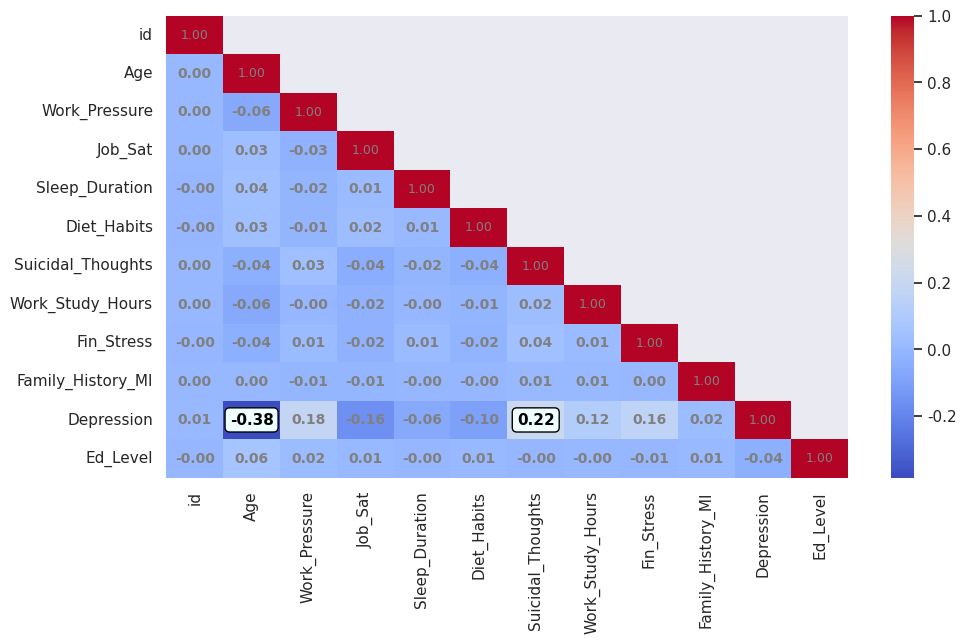

Correlation Heatmap for Student:



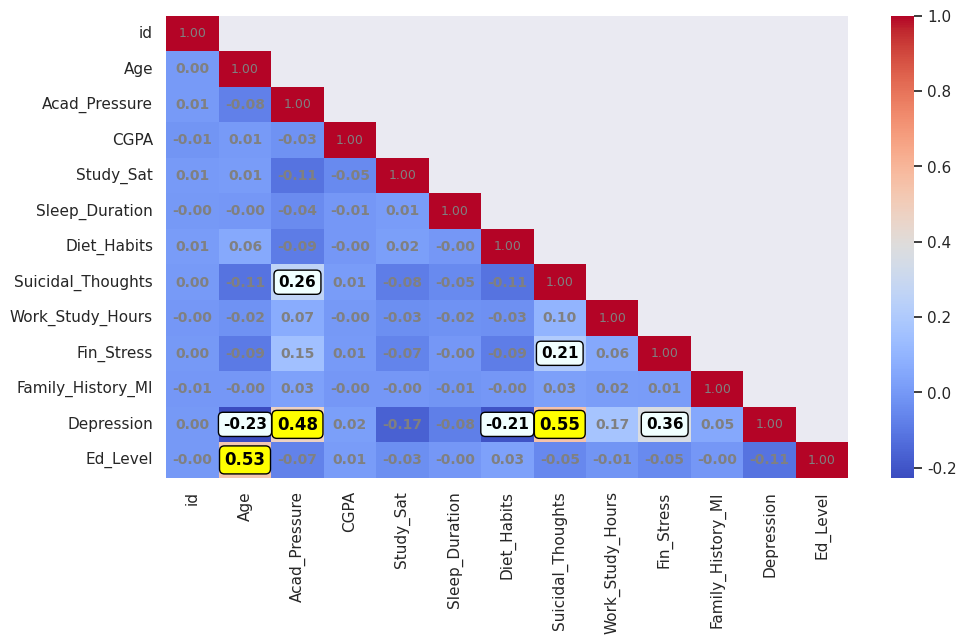

In [35]:
# Correlations
for name, df in dfp: 
    print(f"Correlation Heatmap for {name}:\n")
    
    plt.figure(figsize=(11, 6))
    corr = df.dropna().corr(numeric_only=True)
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    sns.heatmap(corr, annot=False, cmap="coolwarm", mask=mask)
    
    for i in range(len(corr.columns)):
        for j in range(i+1):
            value = corr.iloc[i, j]
            if abs(value) == 1:
                bbox_props = None
                text_color = 'grey'
                weight = 'normal'
                font_size = 9
            elif abs(value) >= 0.7:
                bbox_props = dict(boxstyle='round,pad=0.4',
                                  facecolor='red', edgecolor='black')
                text_color = 'black'
                weight = 900
                font_size = 13
            elif abs(value) >= 0.4:
                bbox_props = dict(boxstyle='round,pad=0.3',
                                  facecolor='yellow', edgecolor='black')
                text_color = 'black'
                weight = 800
                font_size = 12
            elif abs(value) >= 0.2:
                bbox_props = dict(boxstyle='round,pad=0.3',
                                  facecolor='azure', edgecolor='black')
                text_color = 'black'
                weight = 700
                font_size = 11
            else:
                bbox_props = None
                text_color = 'grey'
                weight = 600
                font_size = 10
    
            plt.gca().text(j+0.5, i+0.5, f'{value:.2f}', ha='center', va='center',
                           color=text_color, fontsize=font_size, fontweight=weight, bbox=bbox_props)
    plt.gca().grid(False)
    plt.show()

In [36]:
# Perform chi2 test to check for association between variables and Cramer's V to review the strength of relationship between variables
'''
Strength for correlation if range for abs(corr) between 2 independent variables is
- (0.25, ) : Very Strong (Drop one of the variables)
- (0.15, 0.25) : Strong (Keep)
- (0.10, 0.15) : Moderate (Keep)
- (0.05, 0.10) : Weak (Keep)
- (0, 0.05) : Very Weak (Keep)

Strength for correlation if range for abs(corr) between an independent and a dependent variable is
- (0.25, ) : Very Strong (Keep)
- (0.15, 0.25) : Strong (Keep)
- (0.10, 0.15) : Moderate (Keep)
- (0.05, 0.10) : Weak (Keep)
- (0, 0.05) : Very Weak (Drop)
'''

# Function to calculate Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


# List of categorical variables
col_unique_cat = ['Depression', 'Gender', 'City', 'Profession', 'Work_Pressure', 'Sleep_Duration', 'Diet_Habits', 'Suicidal_Thoughts', 'Work_Study_Hours', 'Fin_Stress', 
                  'Family_History_MI', 'Prof_Grp', 'Ed_Level', 'Ed_Field', 'Job_Sat']

results = []

# Loop through all unique pairs of categorical variables
for col1 in col_unique_cat:
    for col2 in col_unique_cat:
        if col1 != col2:
            # Chi2 Test
            confusion_matrix = pd.crosstab(working_df[col1], working_df[col2])
            chi2, p, _, _ = chi2_contingency(confusion_matrix)
            # Cramer's V
            v = cramers_v(working_df[col1], working_df[col2])
            results.append({"Variable 1": col1, "Variable 2": col2, "Chi2": chi2,
                           "P-value": p, "Association": "YES" if p < 0.05 else "NO", "Cramer's V": v})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Define a function to apply styling based on association
def highlight_association(val):
    return "background-color: limegreen; font-weight: bold" if val == "YES" else ""

# Define a function to apply styling based on Cramer's V

def highlight_cramer(val):
    if val < 0.1:
        return "background-color: grey; font-weight: 500"
    elif val < 0.15:
        return "background-color: lightgray; font-weight: 600"
    elif val < 0.25:
        return "background-color: coral; font-weight: 700"
    else:
        return "background-color: red; font-weight: 800"

# Create a styler object and apply styles to specific columns
# chi2_results_df = results_df[(results_df["Association"]=="YES") & (results_df["Cramer's V"]>0.2)].style.apply(lambda x: [highlight_association(val) if x.name == "Association" else highlight_cramer(val) for val in x], axis=0, subset=["Association", "Cramer's V"])
chi2_results_df = results_df.style.apply(lambda x: [highlight_association(
    val) if x.name == "Association" else highlight_cramer(val) for val in x], axis=0, subset=["Association", "Cramer's V"])
chi2_results_df

,Variable 1,Variable 2,Chi2,P-value,Association,Cramer's V
0,Depression,Gender,6.135296,0.013251,YES,0.006747
1,Depression,City,401.061103,0.000000,YES,0.057278
2,Depression,Profession,1425.848582,0.000000,YES,0.114455
3,Depression,Work_Pressure,6069.812288,0.000000,YES,0.231896
4,Depression,Sleep_Duration,1008.923393,0.000000,YES,0.094388
5,Depression,Diet_Habits,1865.273266,0.000000,YES,0.128490
6,Depression,Suicidal_Thoughts,7237.954783,0.000000,YES,0.253295
7,Depression,Work_Study_Hours,2484.740381,0.000000,YES,0.148090
8,Depression,Fin_Stress,4519.463763,0.000000,YES,0.200079
9,Depression,Family_History_MI,33.084183,0.000000,YES,0.016865


In [37]:
# Perform chi2 test to check for association between variables and Cramer's for Student
# List of categorical variables
col_unique_cat = ['Depression', 'Gender', 'City', 'Acad_Pressure', 'Sleep_Duration', 'Diet_Habits', 'Suicidal_Thoughts', 'Work_Study_Hours', 'Fin_Stress', 
                  'Family_History_MI', 'Ed_Level', 'Ed_Field', 'Study_Sat']

results = []

# Loop through all unique pairs of categorical variables
for col1 in col_unique_cat:
    for col2 in col_unique_cat:
        if col1 != col2:
            # Chi2 Test
            confusion_matrix = pd.crosstab(student_df[col1], student_df[col2])
            chi2, p, _, _ = chi2_contingency(confusion_matrix)
            # Cramer's V
            v = cramers_v(student_df[col1], student_df[col2])
            results.append({"Variable 1": col1, "Variable 2": col2, "Chi2": chi2,
                           "P-value": p, "Association": "YES" if p < 0.05 else "NO", "Cramer's V": v})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Define a function to apply styling based on association
def highlight_association(val):
    return "background-color: limegreen; font-weight: bold" if val == "YES" else ""

# Define a function to apply styling based on Cramer's V

def highlight_cramer(val):
    if val < 0.1:
        return "background-color: grey; font-weight: 500"
    elif val < 0.15:
        return "background-color: lightgray; font-weight: 600"
    elif val < 0.25:
        return "background-color: coral; font-weight: 700"
    else:
        return "background-color: red; font-weight: 800"

# Create a styler object and apply styles to specific columns
# chi2_results_df = results_df[(results_df["Association"]=="YES") & (results_df["Cramer's V"]>0.2)].style.apply(lambda x: [highlight_association(val) if x.name == "Association" else highlight_cramer(val) for val in x], axis=0, subset=["Association", "Cramer's V"])
chi2_results_df = results_df.style.apply(lambda x: [highlight_association(
    val) if x.name == "Association" else highlight_cramer(val) for val in x], axis=0, subset=["Association", "Cramer's V"])
chi2_results_df

,Variable 1,Variable 2,Chi2,P-value,Association,Cramer's V
0,Depression,Gender,0.082658,0.773727,NO,0.000000
1,Depression,City,165.752544,0.000000,YES,0.069754
2,Depression,Acad_Pressure,6426.334635,0.000000,YES,0.479782
3,Depression,Sleep_Duration,275.112384,0.000000,YES,0.098576
4,Depression,Diet_Habits,1202.741434,0.000000,YES,0.207368
5,Depression,Suicidal_Thoughts,8323.866373,0.000000,YES,0.546178
6,Depression,Work_Study_Hours,984.791724,0.000000,YES,0.186823
7,Depression,Fin_Stress,3700.263301,0.000000,YES,0.363982
8,Depression,Family_History_MI,79.434429,0.000000,YES,0.053021
9,Depression,Ed_Level,496.921150,0.000000,YES,0.132919


In [38]:
Xs_train.head()

,id,Name,Gender,Age,City,Status,Acad_Pressure,CGPA,Study_Sat,Sleep_Duration,Diet_Habits,Degree,Suicidal_Thoughts,Work_Study_Hours,Fin_Stress,Family_History_MI,Sleep_Durations,Dietary_Habits,Ed_Levels,Ed_Level,Ed_Field
8551,8551,nishant,male,18.0,jaipur,student,4.0,6.02,1.0,4,1,class 12,1,3.0,5.0,0,7-8 hours,moderate,high school,1,unknown
125925,125925,anand,male,25.0,vadodara,student,3.0,6.37,2.0,4,1,b.arch,0,9.0,1.0,1,7-8 hours,moderate,bachelor,2,architecture
139260,139260,sanjeev,male,30.0,ahmedabad,student,3.0,9.24,2.0,4,0,m.ed,1,5.0,5.0,1,7-8 hours,unhealthy,master,3,education
68491,68491,pranav,male,34.0,bhopal,student,3.0,7.37,5.0,4,1,b.com,1,12.0,3.0,0,7-8 hours,moderate,bachelor,2,commerce
136261,136261,tushar,male,25.0,patna,student,3.0,7.47,4.0,2,0,b.com,0,11.0,5.0,0,5-6 hours,unhealthy,bachelor,2,commerce


In [39]:
# Set 'id' as the index and drop redundant columns
Xw_train = Xw_train.set_index('id').drop(columns=['Name', 'Gender', 'Status', 'Degree', 'Profession', 'Sleep_Durations', 'Dietary_Habits', 'Family_History_MI', 'City'])
Xw_test = Xw_test.set_index('id').drop(columns=['Name', 'Gender', 'Status', 'Degree', 'Profession', 'Sleep_Durations', 'Dietary_Habits', 'Family_History_MI', 'City'])
working_test_df = working_test_df.set_index('id').drop(columns=['Name', 'Gender', 'Status', 'Degree', 'Profession', 'Sleep_Durations', 'Dietary_Habits', 'Family_History_MI', 'City'])

In [40]:
# Set 'id' as the index and drop it from columns
Xs_train = Xs_train.set_index('id').drop(columns=['Name', 'Gender', 'Status', 'Degree', 'Family_History_MI', 'City', 'CGPA', 'Sleep_Durations', 'Dietary_Habits', 'Ed_Field', 'Ed_Level'])
Xs_test = Xs_test.set_index('id').drop(columns=['Name', 'Gender', 'Status', 'Degree', 'Family_History_MI', 'City', 'CGPA', 'Sleep_Durations', 'Dietary_Habits', 'Ed_Field', 'Ed_Level'])
student_test_df = student_test_df.set_index('id').drop(columns=['Name', 'Gender', 'Status', 'Degree', 'Family_History_MI', 'City', 'CGPA', 'Sleep_Durations', 'Dietary_Habits', 'Ed_Field', 'Ed_Level'])

In [41]:
# Perform one hot encoding
Xw_train = pd.get_dummies(Xw_train, columns=['Ed_Field', 'Prof_Grp'], drop_first=True)
Xw_test = pd.get_dummies(Xw_test, columns=['Ed_Field', 'Prof_Grp'], drop_first=True)
df_test_w = pd.get_dummies(df_test_w, columns=['Ed_Field', 'Prof_Grp'], drop_first=True)

# Align df_test columns with df
Xw_test = Xw_test.reindex(columns=Xw_train.columns, fill_value=0)
df_test_w = df_test_w.reindex(columns=Xw_train.columns, fill_value=0)

NameError: name 'df_test_w' is not defined

In [ ]:
# One-Hot Encode 
#Xs_train = pd.get_dummies(Xs_train, columns=['Ed_Field'], drop_first=True)
#Xs_test = pd.get_dummies(Xs_test, columns=['Ed_Field'], drop_first=True)
#df_test_s = pd.get_dummies(df_test_s, columns=['Ed_Field'], drop_first=True)

# Align df_test columns with df
#Xs_test = Xs_test.reindex(columns=Xs_train.columns, fill_value=0)
#df_test_s = df_test_s.reindex(columns=Xs_train.columns, fill_value=0)

In [ ]:
# Perform Scaling for Working Professional
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Continuous columns to scale
continuous_cols = ['Age', 'Work_Study_Hours']

# Columns to scale
ordinal_cols = ['Work_Pressure', 'Job_Sat', 'Sleep_Duration', 'Diet_Habits', 'Fin_Stress', 'Ed_Level']

# Initialize scaler
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()


# Fit and transform on train, transform on test
std_scaler.fit(Xw_train[continuous_cols])
Xw_train[continuous_cols] = std_scaler.transform(Xw_train[continuous_cols])
Xw_test[continuous_cols] = std_scaler.transform(Xw_test[continuous_cols])
df_test_w[continuous_cols] = std_scaler.transform(df_test_w[continuous_cols])


mm_scaler.fit(Xw_train[ordinal_cols])
Xw_train[ordinal_cols] = mm_scaler.fit_transform(Xw_train[ordinal_cols])
Xw_test[ordinal_cols] = mm_scaler.fit_transform(Xw_test[ordinal_cols])
df_test_w[ordinal_cols] = mm_scaler.transform(df_test_w[ordinal_cols])

In [ ]:
# Perform Scaling for Student
# Continuous columns to scale
continuous_cols = ['Age', 'Work_Study_Hours']

# Columns to scale
ordinal_cols = ['Acad_Pressure', 'Study_Sat', 'Sleep_Duration', 'Diet_Habits', 'Fin_Stress']

# Initialize scaler
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

# Fit and transform on train, transform on test
Xs_train[continuous_cols] = std_scaler.fit_transform(Xs_train[continuous_cols])
Xs_test[continuous_cols] = std_scaler.transform(Xs_test[continuous_cols])
df_test_s[continuous_cols] = std_scaler.transform(df_test_s[continuous_cols])

Xs_train[ordinal_cols] = mm_scaler.fit_transform(Xs_train[ordinal_cols])
Xs_test[ordinal_cols] = mm_scaler.fit_transform(Xs_test[ordinal_cols])
df_test_s[ordinal_cols] = mm_scaler.transform(df_test_s[ordinal_cols])

In [ ]:
import itertools
from matplotlib.cbook import boxplot_stats
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fowlkes_mallows_score, matthews_corrcoef, roc_auc_score, roc_curve, precision_recall_curve, make_scorer, classification_report

In [ ]:
def model_cross_validation_perf(clfs, X, y):
    print(f"\nCross-Validation Performance:\n")
    results = []
    names = []

    for name, clf in clfs:
        # Preprocess data only for logistic regression models
        if isinstance(clf, (LogisticRegression, LogisticRegressionCV)):
            X_preprocessed = sm.add_constant(X, has_constant="add")
        else:
            X_preprocessed = X

        # Stratified K-Fold cross-validation
        kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        
        try:
            # Perform cross-validation
            cv_scores = cross_val_score(
                estimator=clf, X=X_preprocessed, y=y, scoring="accuracy", cv=kfold
            )
            results.append(cv_scores)
            names.append(name)
            print(f"{name}: Mean Score = {cv_scores.mean():.4f}, Std Dev = {cv_scores.std():.4f}")
        except ValueError as e:
            print(f"Error for classifier {name}: {e}")
    
    # Compile results
    cv_results = pd.DataFrame({
        "Classifier": names,
        "Mean Score": [np.mean(result) for result in results],
        "Std Deviation": [np.std(result) for result in results]
    })
    
    # Highlight best and worst classifiers
    styled_results = (cv_results.style
                      .highlight_max(subset=["Mean Score"], props="background-color: lightgreen; font-weight: bold")
                      .highlight_min(subset=["Mean Score"], props="background-color: lightcoral; font-weight: bold")
                      .highlight_max(subset=["Std Deviation"], props="background-color: lightcoral; font-weight: bold")
                      .highlight_min(subset=["Std Deviation"], props="background-color: lightgreen; font-weight: bold"))
    
    display(styled_results)
    return results, names

In [ ]:
# Define a function to generate boxplots to compare models" performance
def boxplot_cv(results, names):
    fig, ax = plt.subplots(figsize=(18, 6))

    bp = ax.boxplot(results, patch_artist=True, widths=0.5,
                    meanline=True, showmeans=True)

    for patch in bp["boxes"]:
        patch.set_facecolor("skyblue")
        patch.set_edgecolor("black")

    for median in bp["medians"]:
        median.set_color("black")
        median.set_linewidth(2)

    for whisker in bp["whiskers"]:
        whisker.set_color("black")
        whisker.set_linewidth(2)

    for cap in bp["caps"]:
        cap.set_color("black")
        cap.set_linewidth(2)

    # Add mean lines for each boxplot
    for i, line in enumerate(bp['means']):
        x, y = line.get_xydata()[1]
        plt.text(x+0.01, y, f'{np.mean(results[i]):.2f}',
                 verticalalignment='center', color='navy', fontsize=14, fontweight=700)

    ax.set_title("Classifier Comparison", fontsize=18, fontweight=700)
    ax.set_xlabel("\nAlgorithm", fontsize=14)
    ax.set_ylabel("Score\n", fontsize=14)
    ax.yaxis.grid(True, linestyle="-", linewidth=0.5)
    ax.set_xticklabels(names, rotation=90)
    ax.set_facecolor("white")
    ax.spines[["top", "right"]].set_visible(False)
    ax.spines[["left", "bottom"]].set_color("black")

    plt.show()

In [ ]:
def find_optimal_threshold(clf, X_test, y_test, metric="accuracy", step=0.01):
    """
    Finds the optimal threshold for a classifier based on a specified metric.
    """
    try:
        y_probs = clf.predict_proba(X_test)[:, 1]
    except AttributeError:
        raise AttributeError(f"The classifier '{clf}' does not support `predict_proba`.")

    thresholds = np.arange(0, 1 + step, step)
    scores = []

    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        if metric == "accuracy":
            scores.append(accuracy_score(y_test, y_pred))
        elif metric == "f1":
            scores.append(f1_score(y_test, y_pred, zero_division=0))
        else:
            raise ValueError(f"Unsupported metric '{metric}' for threshold optimization.")

    optimal_idx = np.argmax(scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

In [ ]:
def get_metrics_scores(clf, X, y, threshold):
    """
    Compute evaluation metrics for a classifier at a specific threshold.
    """
    try:
        y_probs = clf.predict_proba(X)[:, 1]
    except AttributeError:
        raise AttributeError(f"The classifier '{clf}' does not support `predict_proba`.")

    y_pred = (y_probs >= threshold).astype(int)

    metrics = {
        "Threshold": threshold,
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred, zero_division=0),
        "Recall": recall_score(y, y_pred, zero_division=0),
        "F1": f1_score(y, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y, y_probs),
        "MCC": matthews_corrcoef(y, y_pred),
        "FMI": fowlkes_mallows_score(y, y_pred)
    }
    return metrics

In [ ]:
def model_perf(clfs, Xfit, yfit, X, y, threshold_optimization="accuracy"):
    """
    Evaluate classifiers with dynamic thresholds and return/display results after each algorithm.
    """
    all_results = {}

    for name, clf in clfs:
        print(f"\nRunning evaluation for classifier: {name}")

        # Fit the classifier
        try:
            clf.fit(Xfit, yfit)
        except Exception as e:
            print(f"Error fitting classifier '{name}': {e}")
            continue

        # Find optimal threshold based on the specified optimization criterion
        try:
            optimal_threshold = find_optimal_threshold(clf, X, y, metric=threshold_optimization)
        except Exception as e:
            print(f"Error finding optimal threshold for '{name}': {e}")
            continue

        # Collect metrics
        try:
            train_metrics = get_metrics_scores(clf, Xfit, yfit, threshold=optimal_threshold)
            train_metrics["Dataset"] = "Train"
            test_metrics = get_metrics_scores(clf, X, y, threshold=optimal_threshold)
            test_metrics["Dataset"] = "Test"
        except Exception as e:
            print(f"Error calculating metrics for '{name}': {e}")
            continue

        # Combine results
        combined_metrics = pd.DataFrame([train_metrics, test_metrics])
        combined_metrics.insert(0, "Classifier", name)
        

        # Display results for this classifier
        display(combined_metrics)

        # Store results
        all_results[name] = {
            "optimal_threshold": optimal_threshold,
            "metrics": combined_metrics
        }

    return all_results

In [ ]:
# Define class imbalance ratio 
positive_class_count = yw_train.sum()
negative_class_count = len(yw_train) - positive_class_count
imbalance_ratio = negative_class_count / positive_class_count
print(f"Imbalanced ratio: {imbalance_ratio}")

In [ ]:
# Define classifiers
wclassifiers = [
    # Linear Models
    ("Logistic Regression (newton-cg)", LogisticRegression(solver="newton-cg", class_weight="balanced", random_state=42)),
    ("Logistic Regression (liblinear)", LogisticRegression(solver="liblinear", class_weight="balanced", random_state=42)),
    ("Logistic Regression (sag)", LogisticRegression(solver="sag", class_weight="balanced", random_state=42)),
    ("Logistic Regression (saga)", LogisticRegression(solver="saga", class_weight="balanced", random_state=42)),
    ("Logistic Regression (lbfgs)", LogisticRegression(solver="lbfgs", class_weight="balanced", random_state=42)),

    # Tree-Based Models
    ("Decision Trees", DecisionTreeClassifier(class_weight="balanced", random_state=42)),
    ("Random forest", RandomForestClassifier(class_weight="balanced", random_state=42)),
    ("Extra Trees", ExtraTreesClassifier(class_weight="balanced", random_state=42)),

    # Boosting Methods
    ("Adaboost", AdaBoostClassifier(random_state=42)),
    ("GBM", GradientBoostingClassifier(random_state=42)),
    ("XGboost", XGBClassifier(scale_pos_weight=imbalance_ratio, random_state=42, eval_metric="logloss")),
    ("CatBoost", CatBoostClassifier(auto_class_weights="Balanced", silent=True, random_state=42)),
    ("LightGBM", LGBMClassifier(class_weight="balanced", verbosity=0, random_state=42)),

    # Nearest Neighbor Models
    ("K-Nearest Neighbors", KNeighborsClassifier()),  

    # Naive Bayes Models
    ("Gaussian Naive Bayes", GaussianNB()),  
    ("Bernoulli Naive Bayes", BernoulliNB())
]

In [ ]:
# Define classifiers
sclassifiers = [
    # Linear Models
    ("Logistic Regression (newton-cg)", LogisticRegression(solver="newton-cg", random_state=42)),
    ("Logistic Regression (liblinear)", LogisticRegression(solver="liblinear", random_state=42)),
    ("Logistic Regression (sag)", LogisticRegression(solver="sag", random_state=42)),
    ("Logistic Regression (saga)", LogisticRegression(solver="saga", random_state=42)),
    ("Logistic Regression (lbfgs)", LogisticRegression(solver="lbfgs", random_state=42)),

    # Tree-Based Models
    ("Decision Trees", DecisionTreeClassifier(random_state=42)),
    ("Random forest", RandomForestClassifier(random_state=42)),
    ("Extra Trees", ExtraTreesClassifier(random_state=42)),

    # Boosting Methods
    ("Adaboost", AdaBoostClassifier(random_state=42)),
    ("GBM", GradientBoostingClassifier(random_state=42)),
    ("XGboost", XGBClassifier(random_state=42, eval_metric="logloss")),
    ("CatBoost", CatBoostClassifier(silent=True, random_state=42)),
    ("LightGBM", LGBMClassifier(verbosity=0, random_state=42)),

    # Nearest Neighbor Models
    ("K-Nearest Neighbors", KNeighborsClassifier()),  

    # Naive Bayes Models
    ("Gaussian Naive Bayes", GaussianNB()),  
    ("Bernoulli Naive Bayes", BernoulliNB())
]

In [ ]:
# Perform Cross Validation on Working Professional Dataset
cvw_results, cvw_names = model_cross_validation_perf(wclassifiers, Xw_train, yw_train)
boxplot_cv(cvw_results, cvw_names)

# Model evaluation 
wresults = model_perf(wclassifiers, Xw_train, yw_train, Xw_test, yw_test, threshold_optimization="accuracy")

In [ ]:
# Perform Cross Validation on Student Dataset
cvs_results, cvs_names = model_cross_validation_perf(sclassifiers, Xs_train, ys_train)
boxplot_cv(cvs_results, cvs_names)

# Model evaluation 
sresults = model_perf(sclassifiers, Xs_train, ys_train, Xs_test, ys_test, threshold_optimization="accuracy")

In [ ]:
from imblearn.combine import SMOTEENN

# Apply SMOTEENN to the training data
smoteenn = SMOTEENN(random_state=42)
Xw_train_smoteenn, yw_train_smoteenn = smoteenn.fit_resample(Xw_train, yw_train)

In [ ]:
# Perform Cross Validation on Working Professional Dataset
cv_results_smoteenn, cv_names_smoteenn = model_cross_validation_perf(sclassifiers, Xw_train_smoteenn, yw_train_smoteenn)
boxplot_cv(cv_results_smoteenn, cv_names_smoteenn)

# Model evaluation 
results_smoteenn = model_perf(sclassifiers, Xw_train_smoteenn, yw_train_smoteenn, Xw_test, yw_test, threshold_optimization="accuracy")

In [ ]:
# Classifier for Working Professional 
sclfs = [
    # Boosting Methods
    ("Adaboost", AdaBoostClassifier(random_state=42)),
    ("GBM", GradientBoostingClassifier(random_state=42)),
    ("XGboost", XGBClassifier(random_state=42, eval_metric="logloss")),
    ("CatBoost", CatBoostClassifier(silent=True, random_state=42)),
    ("LightGBM", LGBMClassifier(verbosity=-1, random_state=42))
]

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def hyperparameter_tuning(classifiers, param_grids, X_train, y_train, scoring="accuracy", n_iter=10, cv=3):
    best_params = {}

    for clf_name, clf in classifiers:

        if clf_name in param_grids:
            # Define the search object
            search = RandomizedSearchCV(
                estimator=clf,
                param_distributions=param_grids[clf_name],
                scoring=scoring,
                n_iter=n_iter,
                cv=cv,
                random_state=42,
                n_jobs=-1
            )

            # Fit the model
            search.fit(X_train, y_train)

            # Store the best parameters
            best_params[clf_name] = search.best_params_

            print(f"Best parameters for {clf_name}: {search.best_params_}")
            print(f"Best score for {clf_name}: {search.best_score_}")
        else:
            print(f"No hyperparameter tuning defined for {clf_name}.")
        print("--------"*10)

    return best_params

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define hyperparameter grids
param_grids = {
    "Adaboost": {
        "n_estimators": [50, 100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.5, 1.0],
    },
    "GBM": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.5],
        "max_depth": [3, 5, 7],
        "min_samples_split": [5, 10],
        "min_samples_leaf": [1, 4],
    },
    "XGboost": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.5],
        "max_depth": [3, 5, 7],
        "scale_pos_weight": [1, imbalance_ratio],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    },
    "CatBoost": {
        "iterations": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.5],
        "depth": [4, 6, 8],
        "l2_leaf_reg": [3, 5],
    },
    "LightGBM": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.5],
        "num_leaves": [20, 40, 60],
        "min_child_samples": [10, 20, 30],
    },
}

In [ ]:
# Perform hyperparameter tuning on the Working Professional dataset
sbest_parameters = hyperparameter_tuning(sclfs, param_grids, Xs_train, ys_train, scoring="accuracy", n_iter=40, cv=5)

# Display the best parameters
print("Best Parameters for All Classifiers:")
for clf_name, params in sbest_parameters.items():
    print(f"{clf_name}: {params}")

In [ ]:
# Create the tuned classifiers
sbest_classifiers = [
    ("Adaboost", AdaBoostClassifier(random_state=42, **sbest_parameters["Adaboost"])),
    ("GBM", GradientBoostingClassifier(random_state=42, **sbest_parameters["GBM"])),
    ("XGboost", XGBClassifier(random_state=42, eval_metric="logloss", **sbest_parameters["XGboost"])),
    ("CatBoost", CatBoostClassifier(silent=True, random_state=42, **sbest_parameters["CatBoost"])),
    ("LightGBM", LGBMClassifier(verbosity=-1, random_state=42, **sbest_parameters["LightGBM"]))
]

# Review performance metrics on the Student dataset
sbest_results = model_perf(sbest_classifiers, Xs_train, ys_train, Xs_test, ys_test, threshold_optimization="accuracy")


# Create the Voting Classifier
svoting_clf = [("Voting", VotingClassifier(estimators=sbest_classifiers, voting='soft'))]

# Review performance metrics on the Student dataset
sbest_results = model_perf(svoting_clf, Xs_train, ys_train, Xs_test, ys_test, threshold_optimization="accuracy")

In [ ]:
# Classifier for Working Professional 
wclfs = [
    # Boosting Methods
    ("Adaboost", AdaBoostClassifier(random_state=42)),
    ("GBM", GradientBoostingClassifier(random_state=42)),
    ("XGboost", XGBClassifier(scale_pos_weight=imbalance_ratio, random_state=42, eval_metric="logloss")),
    ("CatBoost", CatBoostClassifier(auto_class_weights="Balanced", silent=True, random_state=42)),
    ("LightGBM", LGBMClassifier(class_weight="balanced", verbosity=-1, random_state=42))
]

In [ ]:
# Perform hyperparameter tuning on the Working Professional dataset
wbest_parameters = hyperparameter_tuning(wclfs, param_grids, Xw_train, yw_train, scoring="accuracy", n_iter=40, cv=5)

# Display the best parameters
print("Best Parameters for All Classifiers:")
for clf_name, params in wbest_parameters.items():
    print(f"{clf_name}: {params}")

In [ ]:
# Create the tuned classifiers
wbest_classifiers = [
    ("Adaboost", AdaBoostClassifier(random_state=42, **wbest_parameters["Adaboost"])),
    ("GBM", GradientBoostingClassifier(random_state=42, **wbest_parameters["GBM"])),
    ("XGboost", XGBClassifier(random_state=42, eval_metric="logloss", **wbest_parameters["XGboost"])),
    ("CatBoost", CatBoostClassifier(auto_class_weights="Balanced", silent=True, random_state=42, **wbest_parameters["CatBoost"])),
    ("LightGBM", LGBMClassifier(lass_weight="balanced", verbosity=-1, random_state=42, **wbest_parameters["LightGBM"]))
]

# Review performance metrics on the Student dataset
wbest_results = model_perf(wbest_classifiers, Xw_train, yw_train, Xw_test, yw_test, threshold_optimization="accuracy")


# Create the Voting Classifier
wvoting_clf = [("Voting", VotingClassifier(estimators=wbest_classifiers, voting='soft'))]

# Review performance metrics on the Student dataset
wbest_results_voting = model_perf(wvoting_clf, Xw_train, yw_train, Xw_test, yw_test, threshold_optimization="accuracy")

In [ ]:
voting_clf_w = wvoting_clf[0][1] 
voting_clf_s = svoting_clf[0][1] 

# Fit the voting classifier
voting_clf_w.fit(Xw_train, yw_train)
voting_clf_s.fit(Xs_train, ys_train)

# Make predictions 
voting_predictions_w = voting_clf_w.predict(df_test_w)
voting_predictions_s = voting_clf_s.predict(df_test_s)


# Create a DataFrame for the predictions (including index)
voting_pred_w = pd.DataFrame({"id": df_test_w.index, "Predictions": voting_predictions_w}).set_index("id")
voting_pred_s = pd.DataFrame({"id": df_test_s.index, "Predictions": voting_predictions_s}).set_index("id")

# Combine predictions for working professionals and students
pred7 = pd.concat([voting_pred_w, voting_pred_s])

# Save the combined predictions to a single file
pred7.to_csv("pred7.csv", index=True)

pred7["Predictions"].value_counts()

In [ ]:
voting_clf_w = wvoting_clf[0][1] 
voting_clf_s = svoting_clf[0][1] 

# Fit the voting classifier
voting_clf_w.fit(Xw_train, yw_train)
voting_clf_s.fit(Xs_train, ys_train)

# Make predictions 
voting_predictions_w = voting_clf_w.predict(df_test_w)
voting_predictions_s = voting_clf_s.predict(df_test_s)


# Create a DataFrame for the predictions (including index)
voting_pred_w = pd.DataFrame({"id": df_test_w.index, "Predictions": voting_predictions_w}).set_index("id")
voting_pred_s = pd.DataFrame({"id": df_test_s.index, "Predictions": voting_predictions_s}).set_index("id")

# Combine predictions for working professionals and students
pred1 = pd.concat([voting_pred_w, voting_pred_s])

# Save the combined predictions to a single file
pred1.to_csv("pred1.csv", index=True)

pred1["Predictions"].value_counts()

In [ ]:
voting_clf_w = wvoting_clf[0][1] 
voting_clf_s = svoting_clf[0][1] 

# Fit the voting classifier
voting_clf_w.fit(Xw_train, yw_train)
voting_clf_s.fit(Xs_train, ys_train)

# Make probability predictions
voting_proba_w = voting_clf_w.predict_proba(df_test_w)
voting_proba_s = voting_clf_s.predict_proba(df_test_s)

# Apply thresholds for working professionals and students
threshold_w = 0.59
threshold_s = 0.48

voting_predictions_w = (voting_proba_w[:, 1] >= threshold_w).astype(int)  # Class 1 probability >= 0.59
voting_predictions_s = (voting_proba_s[:, 1] >= threshold_s).astype(int)  # Class 1 probability >= 0.48

# Create DataFrames for the predictions (including index)
voting_pred_w = pd.DataFrame({"id": df_test_w.index, "Predictions": voting_predictions_w}).set_index("id")
voting_pred_s = pd.DataFrame({"id": df_test_s.index, "Predictions": voting_predictions_s}).set_index("id")

# Combine predictions for working professionals and students
pred2 = pd.concat([voting_pred_w, voting_pred_s])

# Save the combined predictions to a single file
pred2.to_csv("pred2.csv", index=True)

# Display the value counts for predictions
print(pred2["Predictions"].value_counts())

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'weights': [
        [1, 1, 1],
        [1, 2, 2],
        [1, 2, 3],
        [2, 3, 3],
        [1, 3, 2],
    ]
}

# Create the VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('LightGBM', LGBMClassifier(verbosity=-1, random_state=42, num_leaves=20, n_estimators=200, min_child_samples=20, learning_rate=0.1)),
        ('CatBoost', CatBoostClassifier(silent=True, random_state=42, learning_rate=0.1, l2_leaf_reg=3, iterations=100, depth=6)),
        ('GBM', GradientBoostingClassifier(random_state=42, n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_depth=3, learning_rate=0.1))
    ],
    voting='soft'
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=voting_clf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy'
)

# Fit the GridSearchCV to the training data
grid_search.fit(Xs_train, ys_train)

# Retrieve the best weights
best_weights = grid_search.best_params_['weights']
best_weights

In [ ]:
# Create the Voting Classifier
svoting_clf2 = [("Voting", VotingClassifier(
    estimators=[
        ("GBM", GradientBoostingClassifier(random_state=42)),
        ("CatBoost", CatBoostClassifier(auto_class_weights="Balanced", silent=True, random_state=42)),
        ("LightGBM", LGBMClassifier(class_weight="balanced", verbosity=-1, random_state=42))
    ],
    voting='soft',
    weights=best_weights
))]

# Review performance metrics on the Student dataset
sbest_results2 = model_perf(svoting_clf, Xs_train, ys_train, Xs_test, ys_test, threshold_optimization="accuracy")

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'weights': [
        [1, 1, 1, 1],
        [1, 2, 2, 1],
        [1, 2, 3, 1],
        [2, 3, 3, 1],
        [1, 3, 2, 2],
        [2, 2, 1, 3],
        [3, 1, 2, 2],
        [1, 2, 1, 3]
    ]
}

# Create the VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
    ("Adaboost", AdaBoostClassifier(random_state=42, **wbest_parameters["Adaboost"])),
    ("GBM", GradientBoostingClassifier(random_state=42, **wbest_parameters["GBM"])),
    ("CatBoost", CatBoostClassifier(auto_class_weights="Balanced", silent=True, random_state=42, **wbest_parameters["CatBoost"])),
    ("LightGBM", LGBMClassifier(lass_weight="balanced", verbosity=-1, random_state=42, **wbest_parameters["LightGBM"]))
    ],
    voting='soft'
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=voting_clf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy'
)

# Fit the GridSearchCV to the training data
grid_search.fit(Xw_train, yw_train)

# Retrieve the best weights
best_weights = grid_search.best_params_['weights']
best_weights

In [ ]:
# Create the Voting Classifier
wvoting_clf2 = [("Voting", VotingClassifier(
    estimators=[
        ('LightGBM', LGBMClassifier(lass_weight="balanced", verbosity=-1, random_state=42, num_leaves=20, n_estimators=200, min_child_samples=20, learning_rate=0.1)),
        ('XGBoost', XGBClassifier(random_state=42, eval_metric="logloss", subsample=1.0, scale_pos_weight=1, n_estimators=300, max_depth=3, learning_rate=0.1, colsample_bytree=0.8)),
        ('GBM', GradientBoostingClassifier(random_state=42, n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_depth=3, learning_rate=0.1)),
        ('AdaBoost', AdaBoostClassifier(random_state=42, n_estimators=100, learning_rate=0.5))
    ],
    voting='soft',
    weights=best_weights
))]


# Review performance metrics on the Student dataset
wbest_results2 = model_perf(wvoting_clf2, Xw_train, yw_train, Xw_test, yw_test, threshold_optimization="accuracy")

In [ ]:
voting_clf_w = wvoting_clf2[0][1] 
voting_clf_s = svoting_clf2[0][1] 

# Fit the voting classifier
voting_clf_w.fit(Xw_train, yw_train)
voting_clf_s.fit(Xs_train, ys_train)

# Make probability predictions
voting_proba_w = voting_clf_w.predict_proba(df_test_w)
voting_proba_s = voting_clf_s.predict_proba(df_test_s)

# Apply thresholds for working professionals and students
threshold_w = 0.58
threshold_s = 0.48

voting_predictions_w = (voting_proba_w[:, 1] >= threshold_w).astype(int)  # Class 1 probability >= 0.59
voting_predictions_s = (voting_proba_s[:, 1] >= threshold_s).astype(int)  # Class 1 probability >= 0.48

# Create DataFrames for the predictions (including index)
voting_pred_w = pd.DataFrame({"id": df_test_w.index, "Predictions": voting_predictions_w}).set_index("id")
voting_pred_s = pd.DataFrame({"id": df_test_s.index, "Predictions": voting_predictions_s}).set_index("id")

# Combine predictions for working professionals and students
pred3 = pd.concat([voting_pred_w, voting_pred_s])

# Save the combined predictions to a single file
pred3.to_csv("pred3.csv", index=True)

# Display the value counts for predictions
print(pred3["Predictions"].value_counts())

In [ ]:
# Create the Voting Classifier
wvoting_clf3 = [("Voting", VotingClassifier(
    estimators=[
        ('XGBoost', XGBClassifier(random_state=42, eval_metric="logloss", subsample=1.0, scale_pos_weight=1, n_estimators=300, max_depth=3, learning_rate=0.1, colsample_bytree=0.8)),
        ('GBM', GradientBoostingClassifier(random_state=42, n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_depth=3, learning_rate=0.1)),
        ('AdaBoost', AdaBoostClassifier(random_state=42, n_estimators=100, learning_rate=0.5))
    ],
    voting='soft'
))]


# Review performance metrics on the Student dataset
wbest_results3 = model_perf(wvoting_clf3, Xw_train, yw_train, Xw_test, yw_test, threshold_optimization="accuracy")

In [ ]:
voting_clf_w = wvoting_clf3[0][1] 
voting_clf_s = svoting_clf[0][1] 

# Fit the voting classifier
voting_clf_w.fit(Xw_train, yw_train)
voting_clf_s.fit(Xs_train, ys_train)

# Make predictions 
voting_predictions_w = voting_clf_w.predict(df_test_w)
voting_predictions_s = voting_clf_s.predict(df_test_s)


# Create a DataFrame for the predictions (including index)
voting_pred_w = pd.DataFrame({"Index": df_test_w.index, "Predictions": voting_predictions_w}).set_index("Index")
voting_pred_s = pd.DataFrame({"Index": df_test_s.index, "Predictions": voting_predictions_s}).set_index("Index")

# Combine predictions for working professionals and students
pred4 = pd.concat([voting_pred_w, voting_pred_s])

# Save the combined predictions to a single file
pred4.to_csv("pred4.csv", index=True)

pred4["Predictions"].value_counts()

In [ ]:
qwbest_classifiers = [
    ("Adaboost", AdaBoostClassifier(random_state=42, **{'n_estimators': 300, 'learning_rate': 1.0})),
    ("GBM", GradientBoostingClassifier(random_state=42, **{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.1})),
    ("XGboost", XGBClassifier(random_state=42, eval_metric="logloss", **{'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8})),
    ("CatBoost", CatBoostClassifier(auto_class_weights="Balanced", silent=True, random_state=42, **{'learning_rate': 0.5, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 8})),
    ("LightGBM", LGBMClassifier(lass_weight="balanced", verbosity=-1, random_state=42, **{'num_leaves': 60, 'n_estimators': 200, 'min_child_samples': 20, 'learning_rate': 0.5}))
]

In [ ]:
# voting_clf_w = wvoting_clf2[0][1] 
voting_clf_s = svoting_clf2[0][1] 

xgb_w = XGBClassifier(random_state=42, eval_metric="logloss", **{'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8})

# Fit the voting classifier
xgb_w.fit(Xw_train, yw_train)
voting_clf_s.fit(Xs_train, ys_train)

# Make probability predictions
xgb_proba_w = xgb_w.predict_proba(df_test_w)
voting_proba_s = voting_clf_s.predict_proba(df_test_s)

# Apply thresholds for working professionals and students
threshold_w = 0.59
threshold_s = 0.48

xgb_predictions_w = (xgb_proba_w[:, 1] >= threshold_w).astype(int)  # Class 1 probability >= 0.59
voting_predictions_s = (voting_proba_s[:, 1] >= threshold_s).astype(int)  # Class 1 probability >= 0.48

# Create DataFrames for the predictions (including index)
xgb_pred_w = pd.DataFrame({"id": df_test_w.index, "Predictions": xgb_predictions_w}).set_index("id")
voting_pred_s = pd.DataFrame({"id": df_test_s.index, "Predictions": voting_predictions_s}).set_index("id")

# Combine predictions for working professionals and students
pred5 = pd.concat([xgb_pred_w, voting_pred_s])

# Save the combined predictions to a single file
pred5.to_csv("pred5.csv", index=True)

# Display the value counts for predictions
print(pred5["Predictions"].value_counts())

In [ ]:
xgb_w = XGBClassifier(random_state=42, eval_metric="logloss", **{'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}) 
gbm_s = GradientBoostingClassifier(random_state=42, **{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.1})

# Fit the voting classifier
xgb_w.fit(Xw_train, yw_train)
gbm_s.fit(Xs_train, ys_train)

# Make predictions 
xgb_predictions_w = xgb_w.predict(df_test_w)
gbm_predictions_s = gbm_s.predict(df_test_s)


# Create a DataFrame for the predictions (including index)
xgb_pred_w = pd.DataFrame({"id": df_test_w.index, "Predictions": xgb_predictions_w}).set_index("id")
gbm_pred_s = pd.DataFrame({"id": df_test_s.index, "Predictions": gbm_predictions_s}).set_index("id")

# Combine predictions for working professionals and students
pred6 = pd.concat([xgb_pred_w, voting_pred_s])

# Save the combined predictions to a single file
pred6.to_csv("pred6.csv", index=True)

pred6["Predictions"].value_counts()

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

# Fit XGBClassifier
model = XGBClassifier(random_state=42, eval_metric="logloss", **{'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8})
model.fit(Xw_train, yw_train)

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(6, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(Xw_test.columns)[sorted_idx])
plt.title('Feature Importance')


In [ ]:
model = xgb.XGBClassifier(random_state=42, eval_metric="logloss", **{'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8})
model.fit(Xs_train, ys_train)

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(6, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(Xs_test.columns)[sorted_idx])
plt.title('Feature Importance')